In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 981.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor

ImportError: ignored

In [ ]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [ ]:
test

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,year,month,day,hour,minute,weekday
0,18,22,3,1.826589,9707,50.0,18,117000,30.0,20.0,...,27.1,1.587063,19,0.002615,2020,6,18,11,58,3
1,5,91,2,25.399386,4150,10.0,13,3810,10.0,10.0,...,14.2,2.663972,6,0.001028,2021,5,26,22,20,2
2,5,46,3,111.079467,5526,20.0,26,10900,10.0,10.0,...,9.3,3.255315,8,0.001743,2019,12,16,0,9,0
3,3,20,1,9.175258,724,30.0,9,55800,20.0,10.0,...,NaN,NaN,2,0.000182,2015,11,16,5,30,0
4,9,67,3,0.000000,837,30.0,19,39800,20.0,10.0,...,NaN,NaN,10,0.000552,2018,10,24,1,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220486,2,77,1,21.712733,4521,60.0,15,298000,30.0,20.0,...,NaN,NaN,13,0.000080,2017,4,4,15,53,1
220487,3,24,1,4.870490,15683,30.0,9,80500,20.0,10.0,...,NaN,NaN,13,0.000039,2016,8,22,16,22,0
220488,9,89,4,17.068286,19169,10.0,14,1200,0.0,0.0,...,27.4,2.405268,23,0.000264,2022,7,10,14,53,6
220489,5,63,2,0.000000,2066,10.0,27,3420,10.0,0.0,...,8.2,2.199039,22,0.000595,2020,12,28,14,38,0


In [ ]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


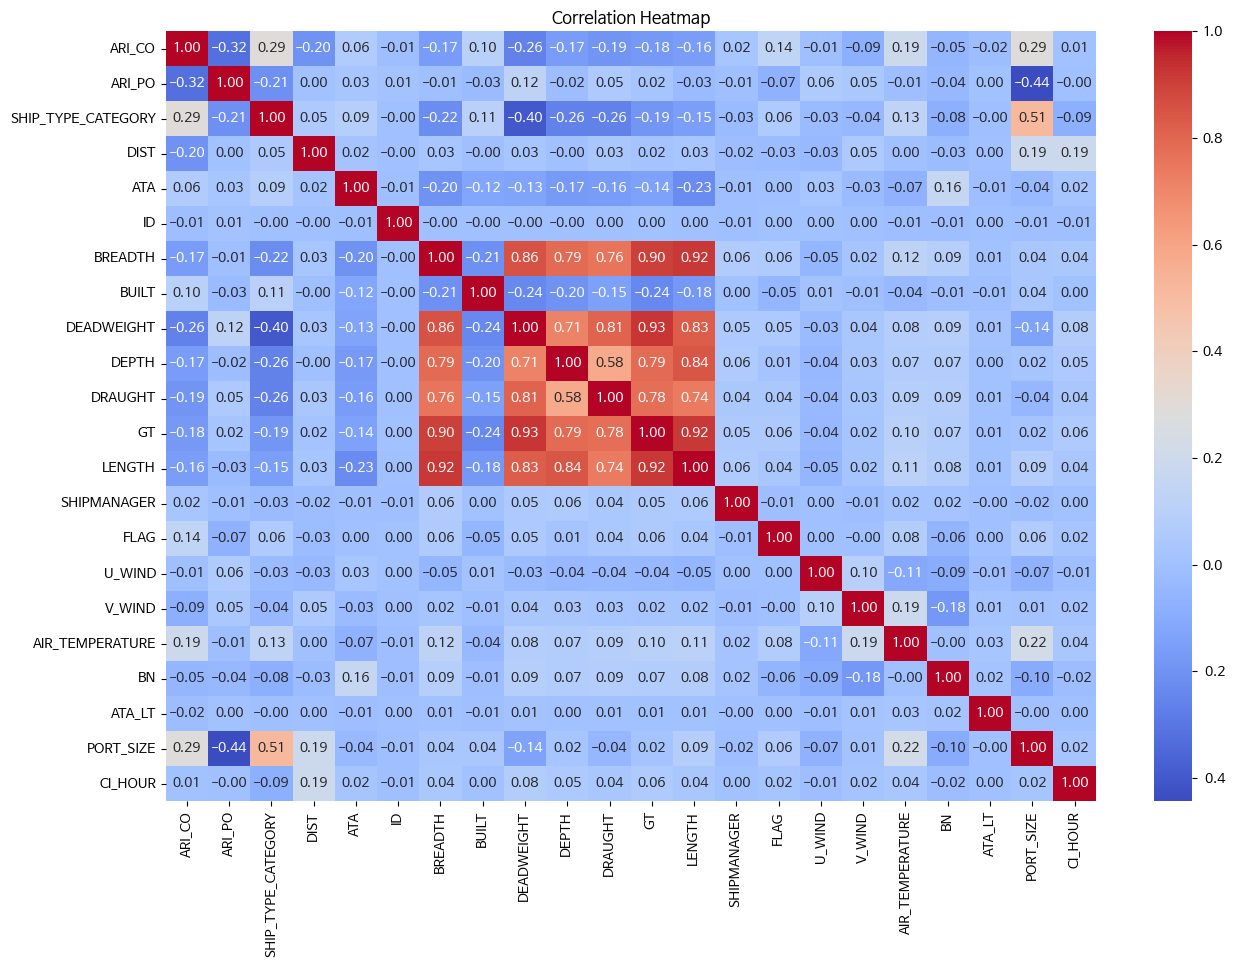

In [ ]:
# 상관 행렬 계산
correlation_matrix = train.corr()

plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [ ]:
# 결측치도 많고 상관관계도 낮은 컬럼 drop하기, CI_HOUR은 target
train = train.drop(columns=['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

In [ ]:
train.isnull().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               1
BUILT                 0
DEADWEIGHT            0
DEPTH                 1
DRAUGHT               1
GT                    0
LENGTH                1
SHIPMANAGER           0
FLAG                  0
ATA_LT                1
PORT_SIZE             1
CI_HOUR               1
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

In [ ]:
# 결측치가 대부분 많이 제거 되었으므로
train.dropna(inplace = True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368248 entries, 0 to 368248
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              368248 non-null  int64  
 1   ARI_PO              368248 non-null  int64  
 2   SHIP_TYPE_CATEGORY  368248 non-null  int64  
 3   DIST                368248 non-null  float64
 4   ID                  368248 non-null  int64  
 5   BREADTH             368248 non-null  float64
 6   BUILT               368248 non-null  int64  
 7   DEADWEIGHT          368248 non-null  int64  
 8   DEPTH               368248 non-null  float64
 9   DRAUGHT             368248 non-null  float64
 10  GT                  368248 non-null  int64  
 11  LENGTH              368248 non-null  float64
 12  SHIPMANAGER         368248 non-null  int64  
 13  FLAG                368248 non-null  int64  
 14  ATA_LT              368248 non-null  float64
 15  PORT_SIZE           368248 non-null  fl

In [ ]:
label = 'CI_HOUR'
save_path = 'RegModel'
predictor = TabularPredictor(label=label, path=save_path, eval_metric='mae').fit(train, presets='best_quality', num_gpus=1)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: RegModel/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "RegModel/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat N

In [ ]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
y_pred = predictor.predict(test)
submit = pd.read_csv('sample_submission.csv')
submit['CI_HOUR'] = pred
submit.to_csv('./submit.csv', index=False)

In [ ]:
perf = predictor.evaluate_predictions(y_true=test, y_pred=y_pred, auxiliary_metrics=True)

In [ ]:
perf